# Lecture 8
_____________


## _Random numbers_

Pseudo-random number generators (PRNGs)

Import libraries

In [ ]:
import numpy as np 
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 600
import pandas as pd

Reference:

http://docs.scipy.org/doc/numpy/reference/routines.random.html

Specify __random seed__ - repeatable results

Generate 10 __random__ values between 0 and 1

In [ ]:
np.random.seed(1)
x = np.random.rand(10)
y = np.random.standard_normal(10)
print(x) # confirm it's the same every time
print(y)

Generate 1000 values __uniformly distributed__ between 15 and 20

In [ ]:
x = np.random.uniform(10, 20, 10000)
print(x)

plt.hist(x, 100)
plt.show()

Generate 1000 values from standard normal distribution

In [ ]:
# standard normal: mean of 0, std of 1

x = np.random.standard_normal(1000)
#print(x)

plt.hist(x)
plt.show()

Generate 1000 __normally distributed__ values with mean 5 and standard deviation 2

In [ ]:
x = np.random.normal(5, 2, 10000)
print(x)

plt.hist(x, 100)
plt.show()

Generate 1000 __lognormal__ values

Careful, mean/std are in real space, not log space

In [ ]:
x = np.random.lognormal(1, 0.5, 100000)
plt.hist(x, 100)
plt.show()

Discrete/combinatorial values

Generate 10 random integers between 0 and 100

Also see `np.random.choice` to choose values from an existing array

In [ ]:
# for working with discrete data (we usually only use continuous data)

np.random.seed(1)
x = np.random.randint(0, 100, 10)
print(x)

x = np.random.permutation(x)
print(x)

----------

## _Autocorrelation_

In [108]:
df = pd.read_csv('data/SHA.csv', index_col=0, parse_dates=True)

Q = df.SHA_INFLOW_CFS # a pandas series (daily)
Q = Q.resample('AS-OCT').sum() # annual values
print(Q.autocorr(lag=1)) # lag (k)

# lag of 1 is slightly negative, but within CI of zero (see below)

-0.10836627171041341


Plot a __correlogram__ with confidence bounds

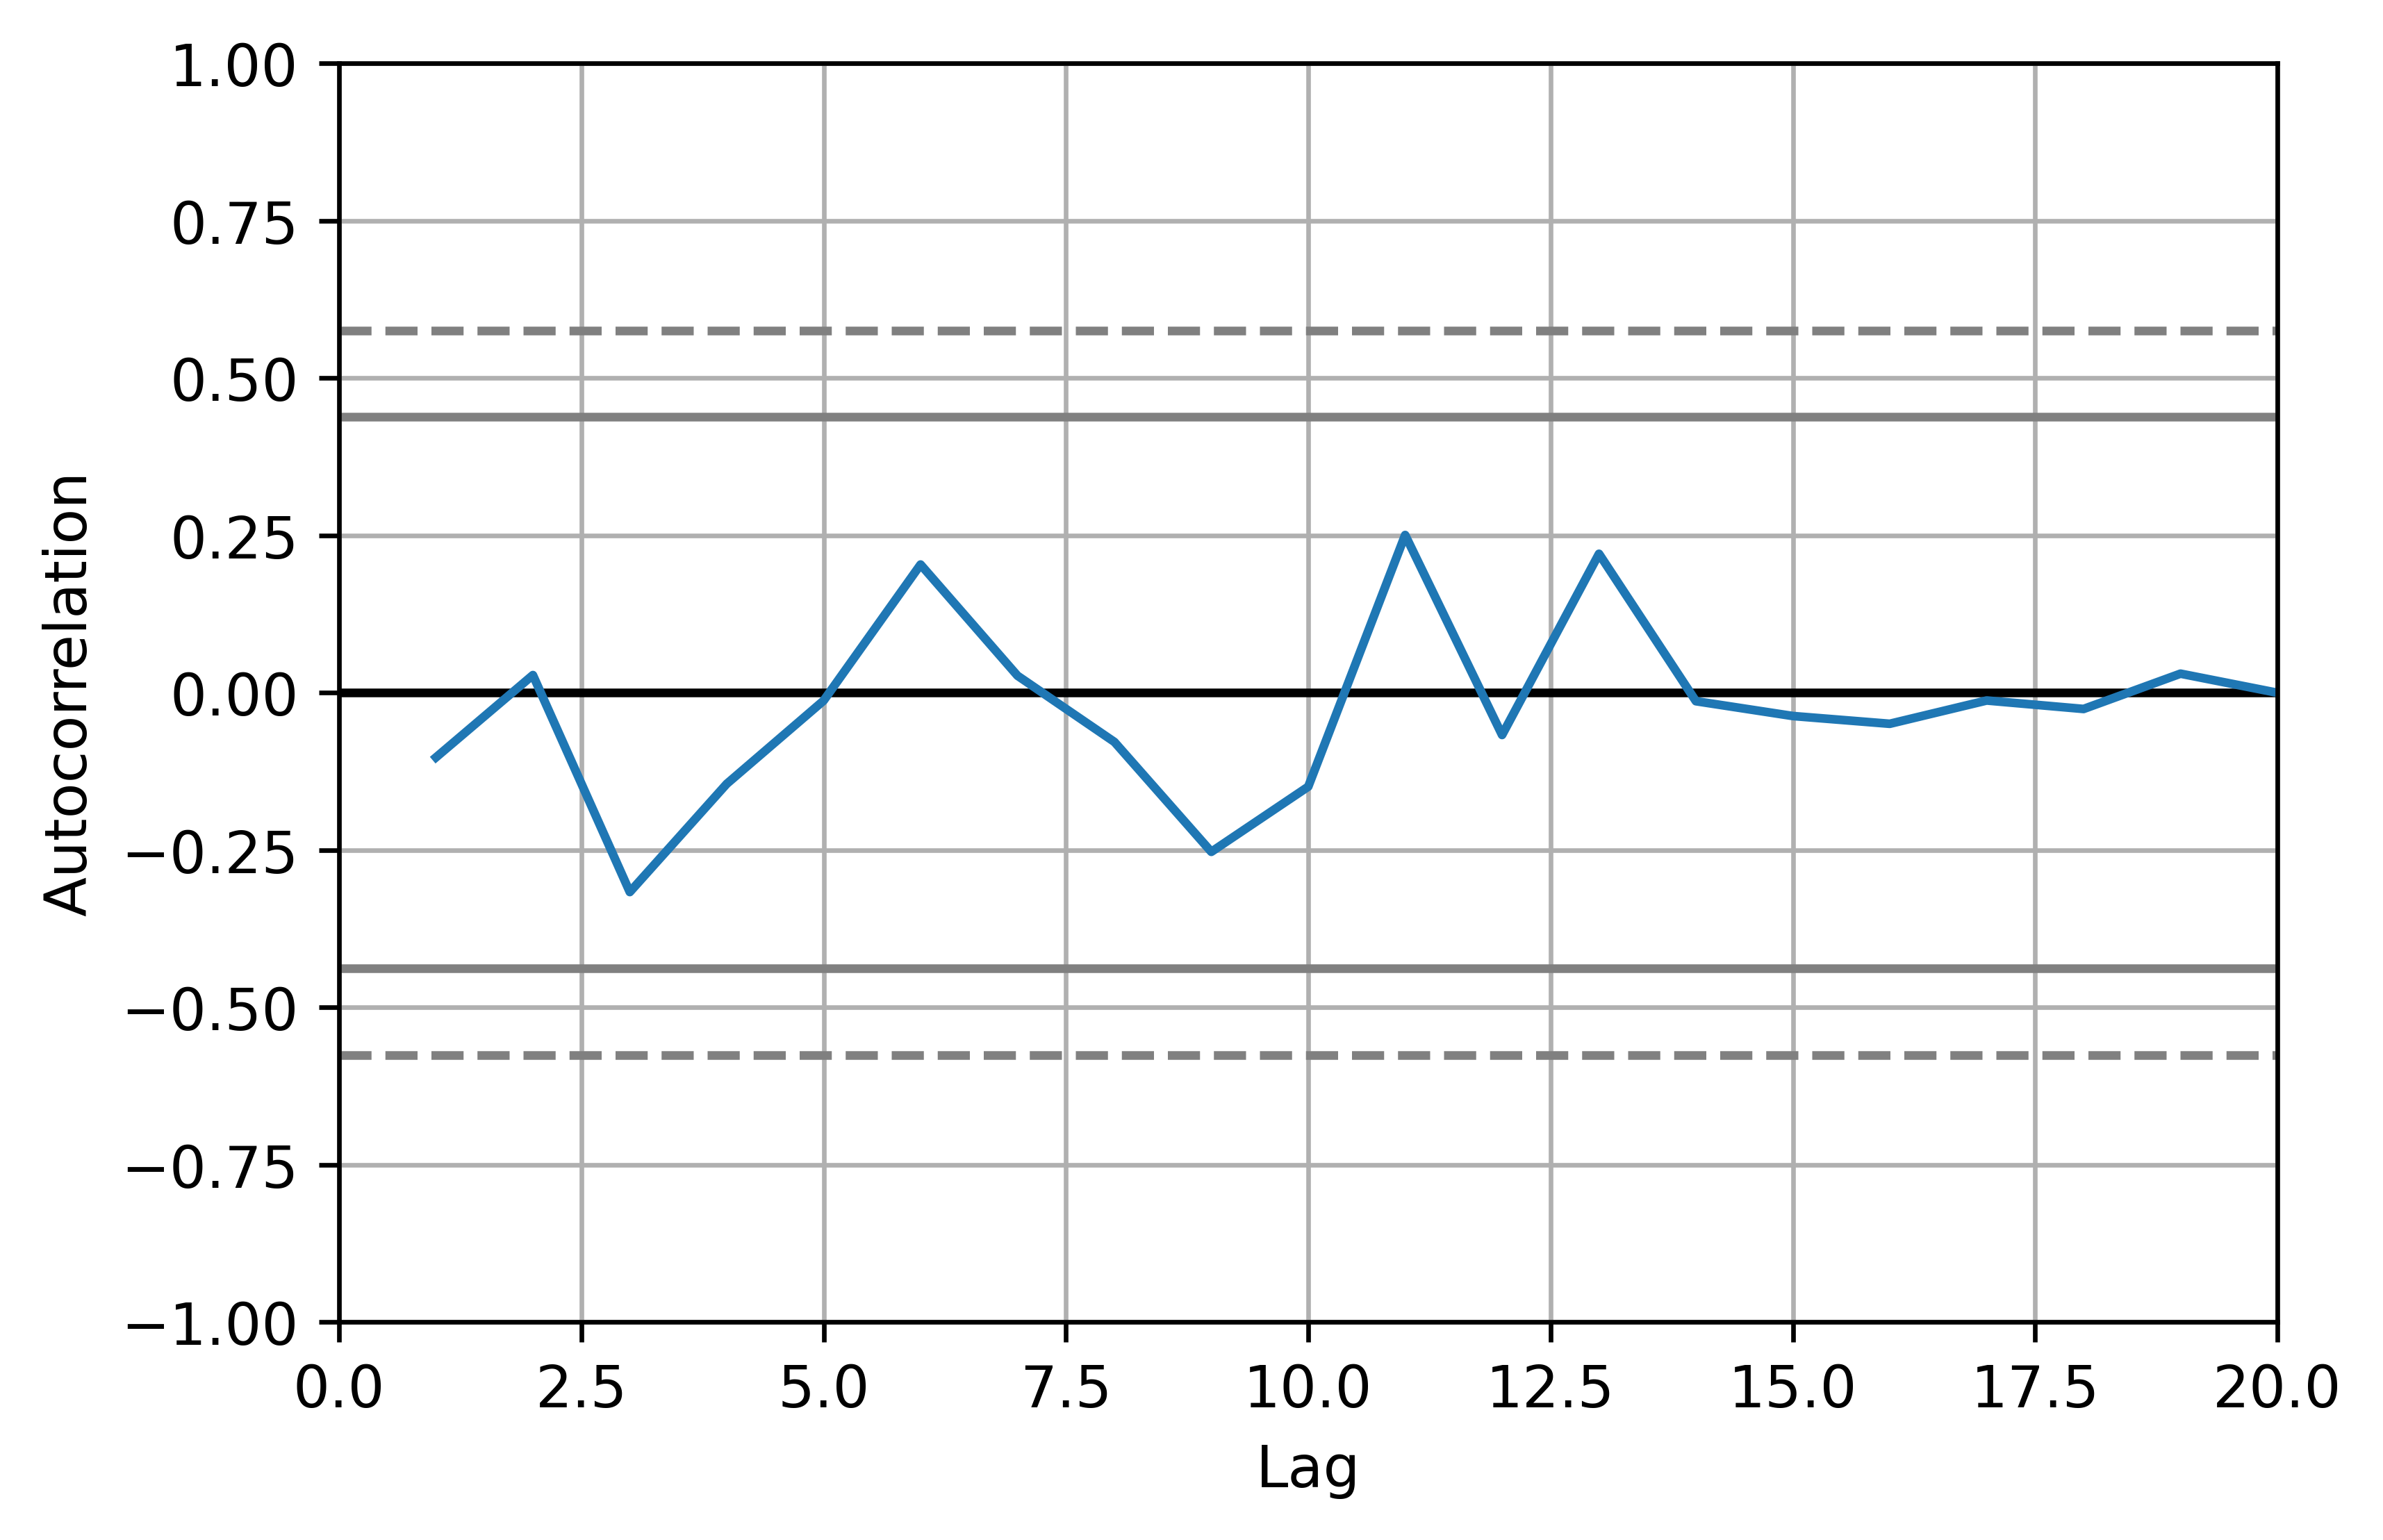

In [109]:
pd.plotting.autocorrelation_plot(Q)
plt.xlim([0,20])
plt.show()

Partial autocorrelation function (PACF)

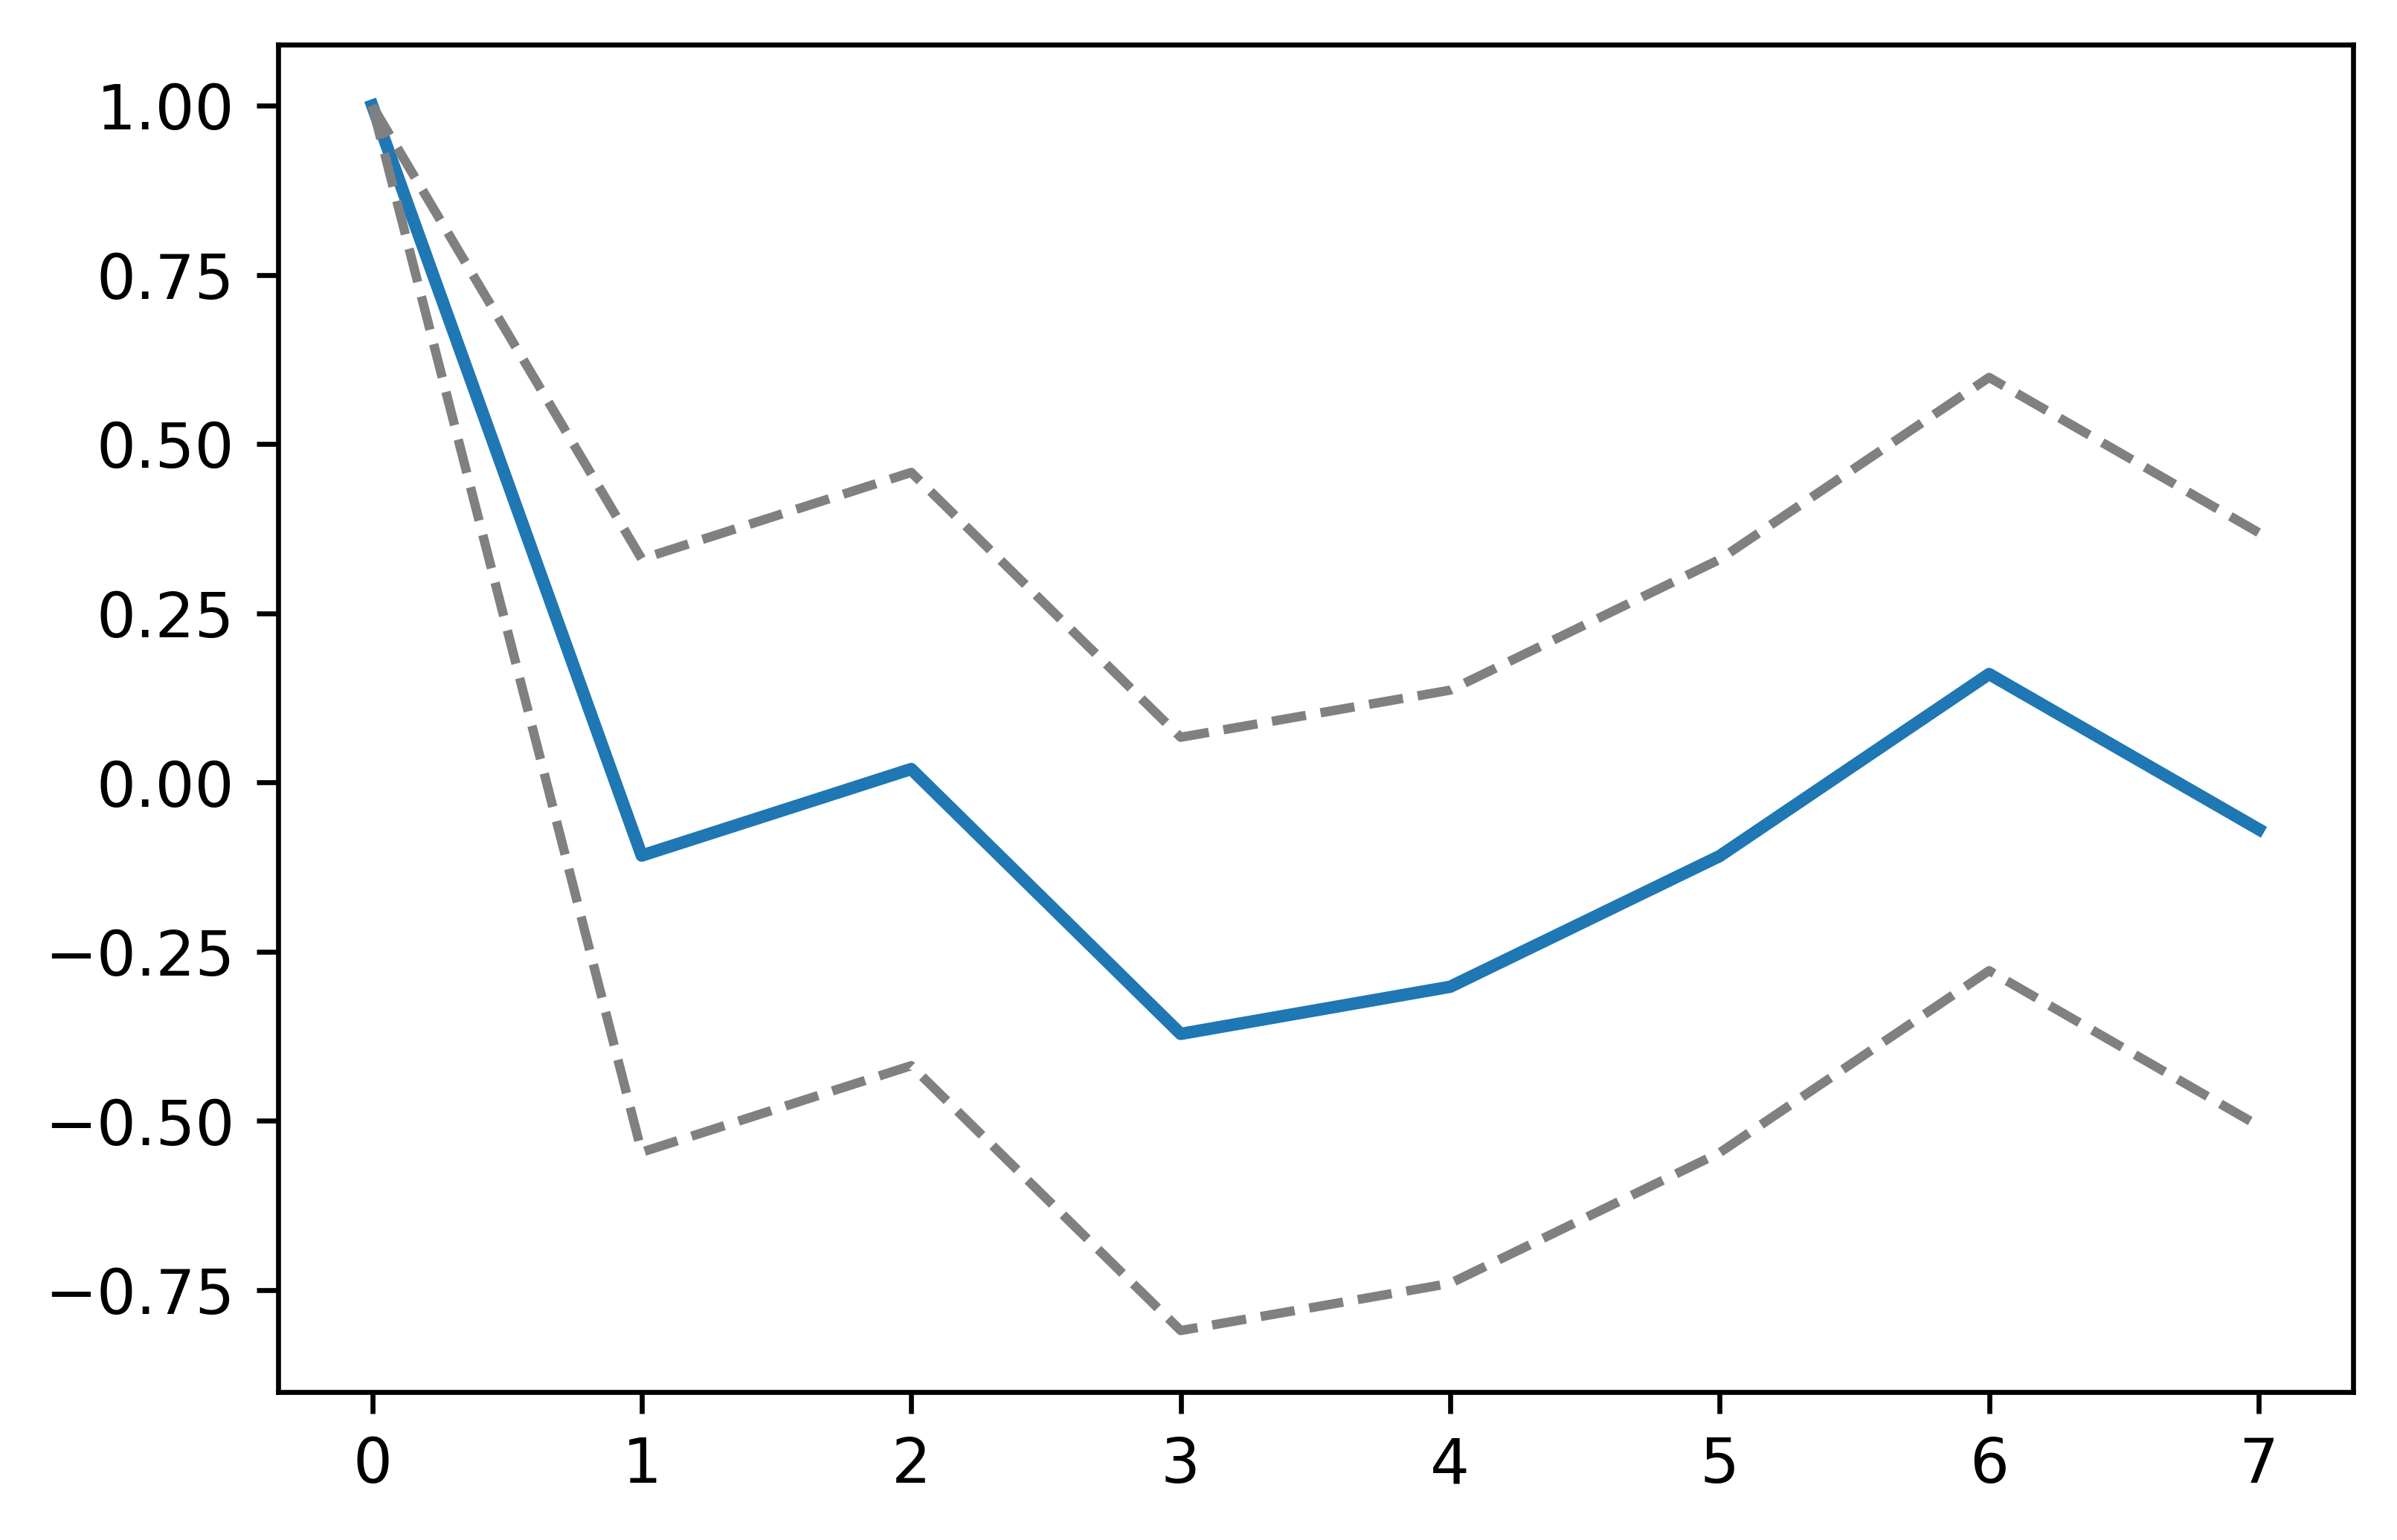

In [110]:
from statsmodels.tsa import stattools
pacf,ci = stattools.pacf(Q, nlags=7, alpha=0.05)
plt.plot(pacf, linewidth=2) # pacf is the partial autocorrelation function
plt.plot(ci, linestyle='dashed', color='0.5')
plt.show()

We did this with `pandas` to simplify the resampling operations, but we can also do it with `numpy` (using annual flow values)

In [111]:
Q = df.SHA_INFLOW_CFS.resample('AS-OCT').sum().values # now a numpy array

In [112]:
def autocorr(x,k):
    return np.corrcoef(x[:len(x)-k], x[k:])[0,1]

In [113]:
print(autocorr(Q,k=1))

-0.1083662717104134


------------

## _Thomas-Fiering method_

Thomas-Fiering (AR-1) method for annual flows

In [116]:
np.random.seed(1)

In [117]:
def autocorr(x,k):
    '''returns the lag-k autocorrelation of vector x'''
    return np.corrcoef(x[:len(x)-k], x[k:])[0,1]

In [118]:
def thomasfiering(x,N):
    '''Lag-1 model. use historical data x 
    to generate a synthetic sequence of N timesteps.
    Assumes x is lognormally distributed.'''
    x = np.log(x) # log-space avoids negative values
    mu = x.mean()
    sigma = x.std()
    rho = autocorr(x,1)
    Q = np.zeros(N) # initialize
    Q[0] = np.random.normal(mu,sigma,1) 
    
    for i in range(1,N):
        Z = np.random.standard_normal() # Z is called V in the L8 slides
        Q[i] = mu + rho*(Q[i-1] - mu) + Z*sigma*np.sqrt(1-rho**2)
    
    return np.exp(Q) # it was in log-transformed space, so exponentiate it to return it to real space

Assume annual flow data is lognormally distributed

This will avoid negative flows

In [129]:
Q = np.loadtxt('data/folsom-annual-flow.csv', delimiter=',', skiprows=1, usecols=[1]) # historical data
Q_synthetic = thomasfiering(Q, N=200) # N=200 is 200 years

In [130]:
print('Means: %f, %f' % (Q.mean(), Q_synthetic.mean()))
print('Stdev: %f, %f' % (Q.std(), Q_synthetic.std()))
print('Rho: %f, %f' % (autocorr(Q,1), autocorr(Q_synthetic,1)))

# note the "retransformation bias" in rho

Means: 2729.264858, 2804.695865
Stdev: 1462.176198, 1558.053032
Rho: 0.051043, 0.040737


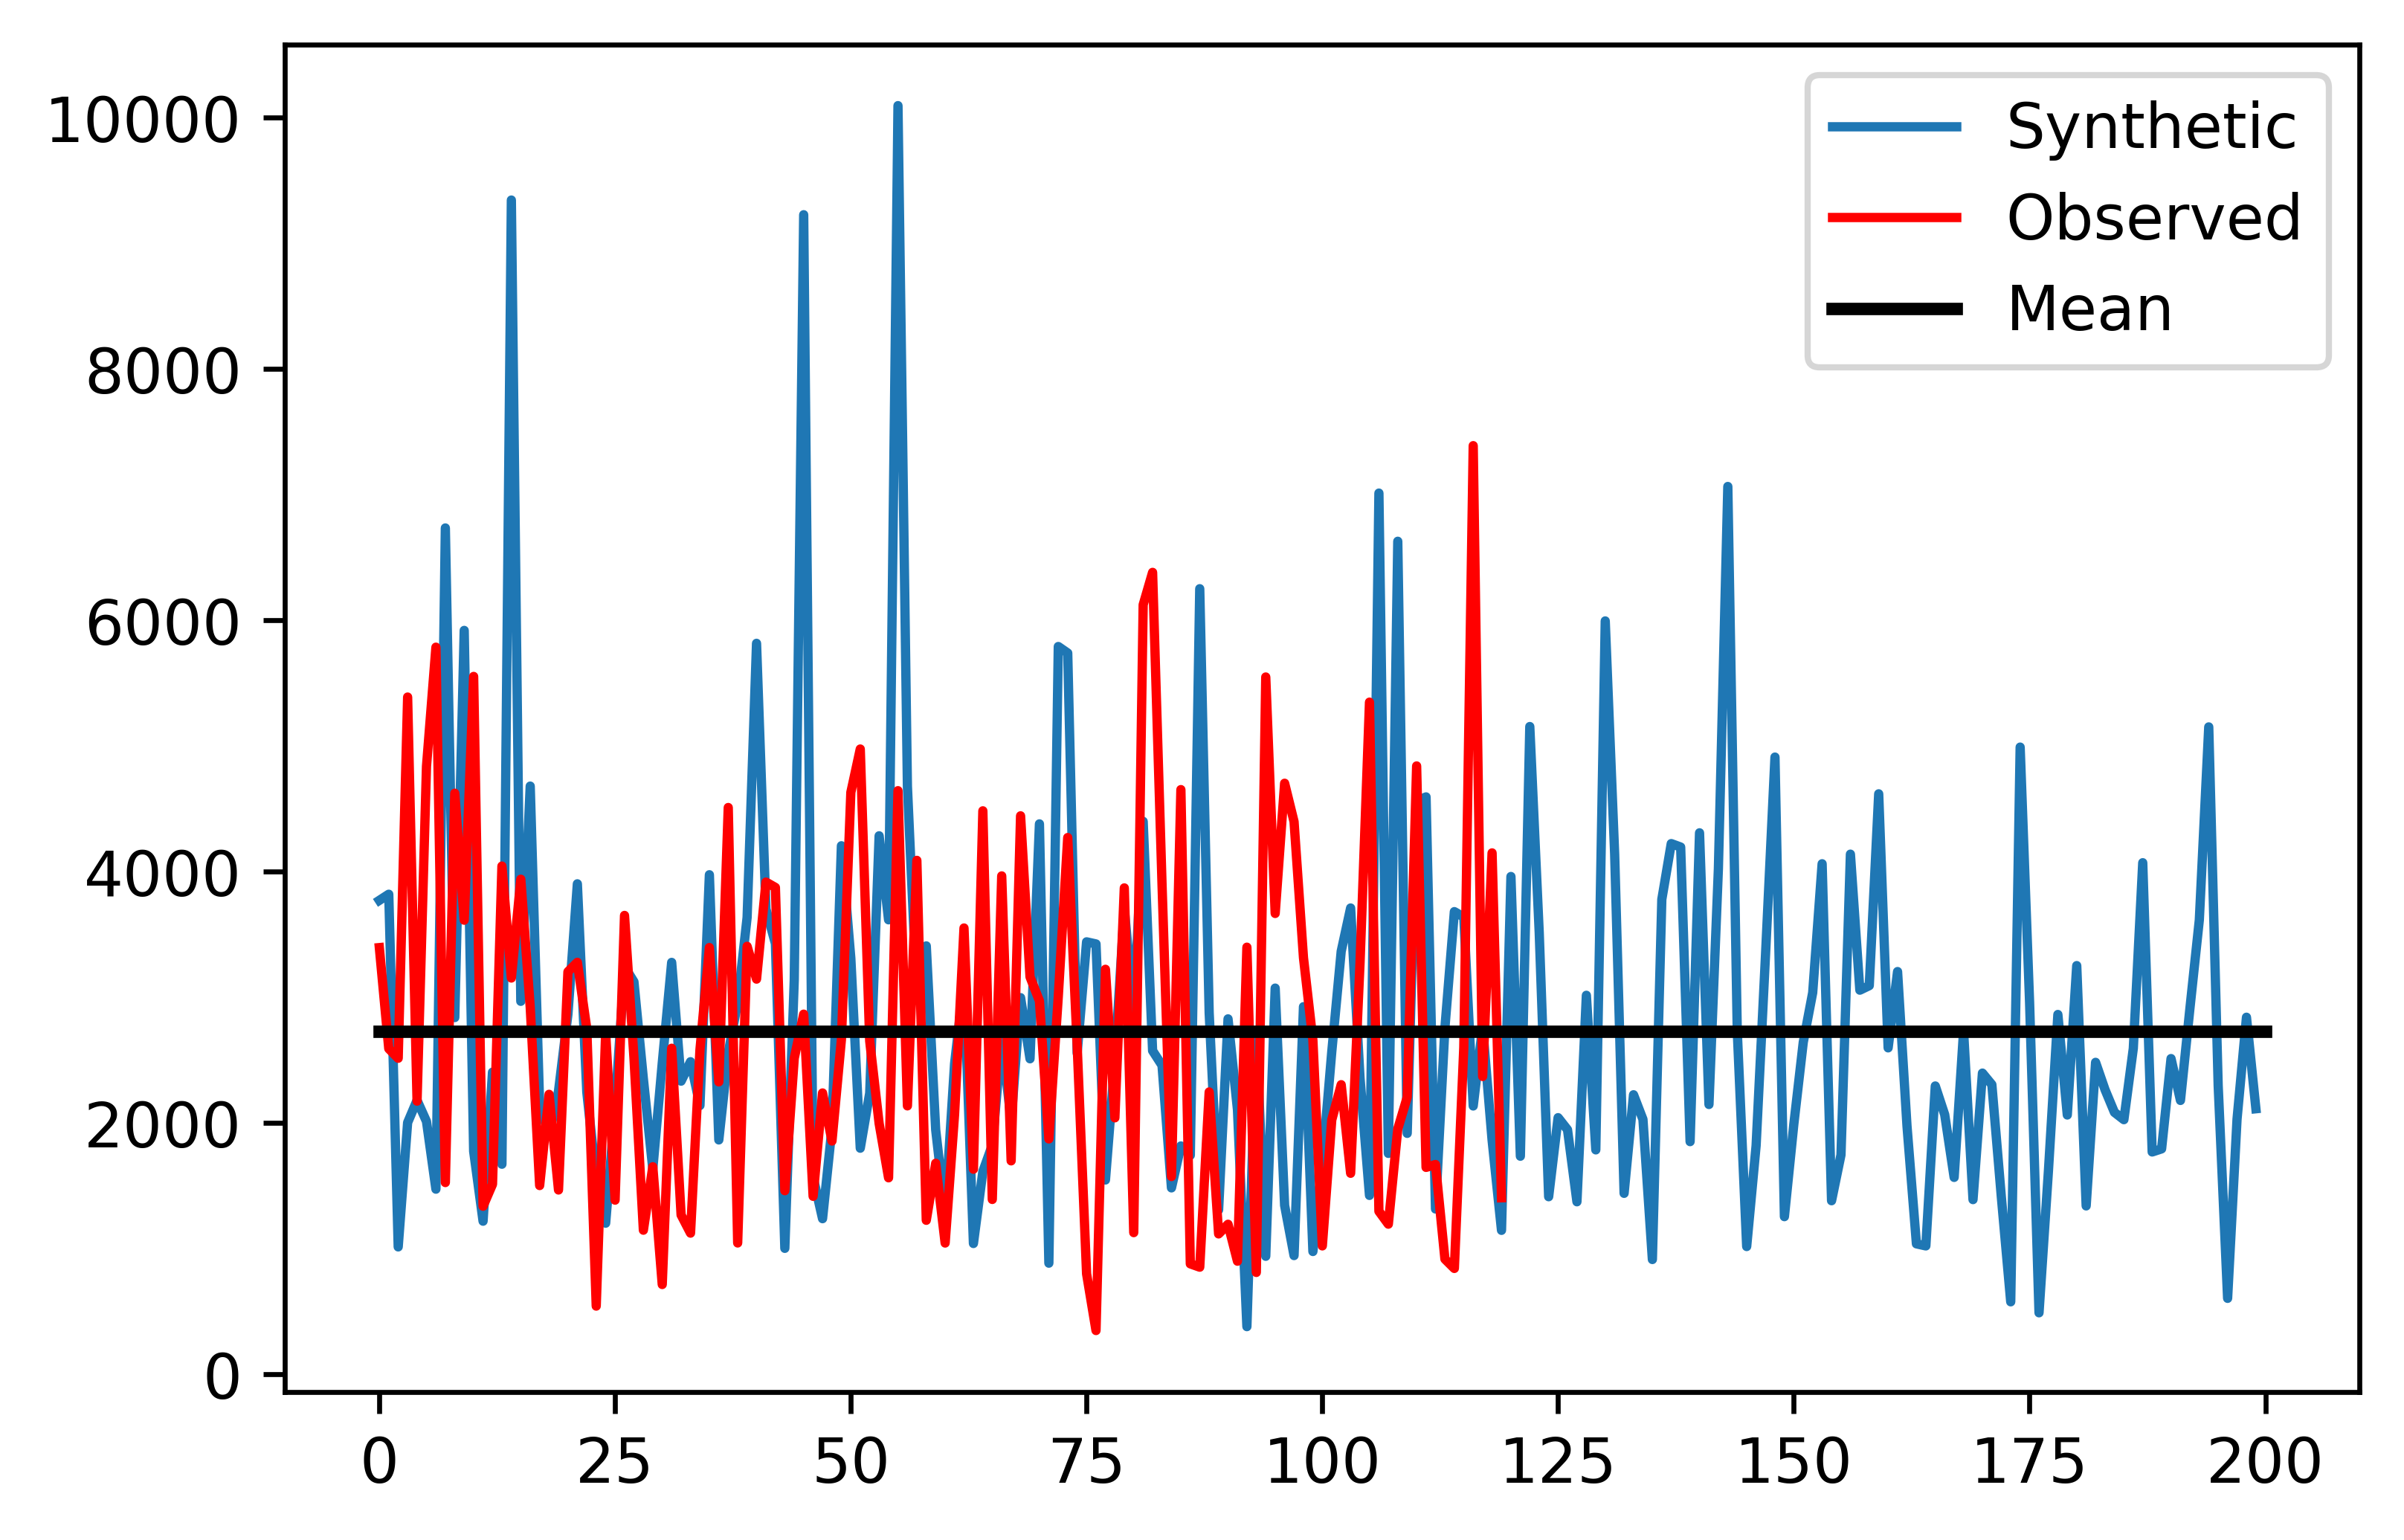

In [131]:
plt.plot(Q_synthetic)
plt.plot(Q, color='red')
plt.plot([0,200], [Q.mean(), Q.mean()], color='k', linewidth=2)
plt.legend(['Synthetic', 'Observed', 'Mean'])
plt.show()

# note the extremes in the synthetic timeseries may not be physically plausible

-----------

## _Thomas-Fiering method (monthly)_

In [132]:
cfs_to_tafd = 2.29568411*10**-5 * 86400 / 1000

In [ ]:
def get_monthly_stats(x):
    '''calculate monthly mean, std. dev., and lag-1 autocorrelation
    from historical data x. Assumes each month is lognormally distributed.'''
    
    x = np.log(x)
    N = len(x)
    mu = np.zeros(12)
    sigma = np.zeros(12)
    rho = np.zeros(12) # varies the autocorrelation
    
    for m in range(12): # loops over all 12 months
        mu[m] = x[m::12].mean() # m::12 is array slicing, picking out every 12; start in month m, go to the end in steps of 12
        sigma[m] = x[m::12].std()
        x1 = x[m:N-1:12]
        x2 = x[m+1::12]
        rho[m] = np.corrcoef(x1,x2)[0,1] # index the matrix
    
    return mu,sigma,rho # log space

In [133]:
# sets up the synthetic data generation
def thomasfiering_monthly(mu, sigma, rho, N_years):
    '''Lag-1 model. use historical monthly statistics to generate 
    a synthetic sequence of N years'''
    
    Q = np.zeros(N_years*12) # initialize
    Q[0] = np.random.normal(mu[0],sigma[0],1)
    
    for y in range(N_years):
        for m in range(12):
            i = 12*y + m # index
            
            if i > 0:
                Z = np.random.standard_normal()
                Q[i] = mu[m] + rho[m-1]*(Q[i-1] - mu[m-1]) + Z*sigma[m]*np.sqrt(1-rho[m-1]**2)
    
    return np.exp(Q) # real space 

Read in data and generate synthetic timeseries

In [134]:
df = pd.read_csv('data/FOL.csv', index_col=0, parse_dates=True)
Q = (cfs_to_tafd * df.FOL_INFLOW_CFS).resample('M').sum().values
mu,sigma,rho = get_monthly_stats(Q)
Q_synthetic = thomasfiering_monthly(mu, sigma, rho, N_years=20)

Compare synthetic stats to historical

In [136]:
a,b,c = get_monthly_stats(Q_synthetic)

for m in range(12):
    print('Month %d means: %f, %f' % (m,mu[m],a[m]))
for m in range(12):
    print('Month %d stdev: %f, %f' % (m,sigma[m],b[m]))
for m in range(12):
    print('Month %d rho: %f, %f' % (m,rho[m],c[m]))

Month 0 means: 3.987923, 3.973443
Month 1 means: 4.243601, 4.385453
Month 2 means: 5.095771, 5.366161
Month 3 means: 5.201600, 5.537281
Month 4 means: 5.359535, 5.431085
Month 5 means: 5.724375, 5.783547
Month 6 means: 5.721638, 5.753931
Month 7 means: 5.617458, 5.610423
Month 8 means: 5.043233, 5.016233
Month 9 means: 4.628251, 4.588715
Month 10 means: 4.556654, 4.484224
Month 11 means: 4.373364, 4.317152
Month 0 stdev: 0.465933, 0.558528
Month 1 stdev: 0.536160, 0.520572
Month 2 stdev: 0.781824, 0.770265
Month 3 stdev: 0.832267, 0.635787
Month 4 stdev: 0.734042, 0.793331
Month 5 stdev: 0.679877, 0.805040
Month 6 stdev: 0.705977, 0.741165
Month 7 stdev: 0.726873, 0.682370
Month 8 stdev: 0.788472, 0.630676
Month 9 stdev: 0.472294, 0.589120
Month 10 stdev: 0.273002, 0.560044
Month 11 stdev: 0.296595, 0.505341
Month 0 rho: 0.696691, 0.524800
Month 1 rho: 0.640248, 0.536057
Month 2 rho: 0.735674, 0.742268
Month 3 rho: 0.704371, 0.827138
Month 4 rho: 0.569506, 0.711406
Month 5 rho: 0.86364

Plot timeseries

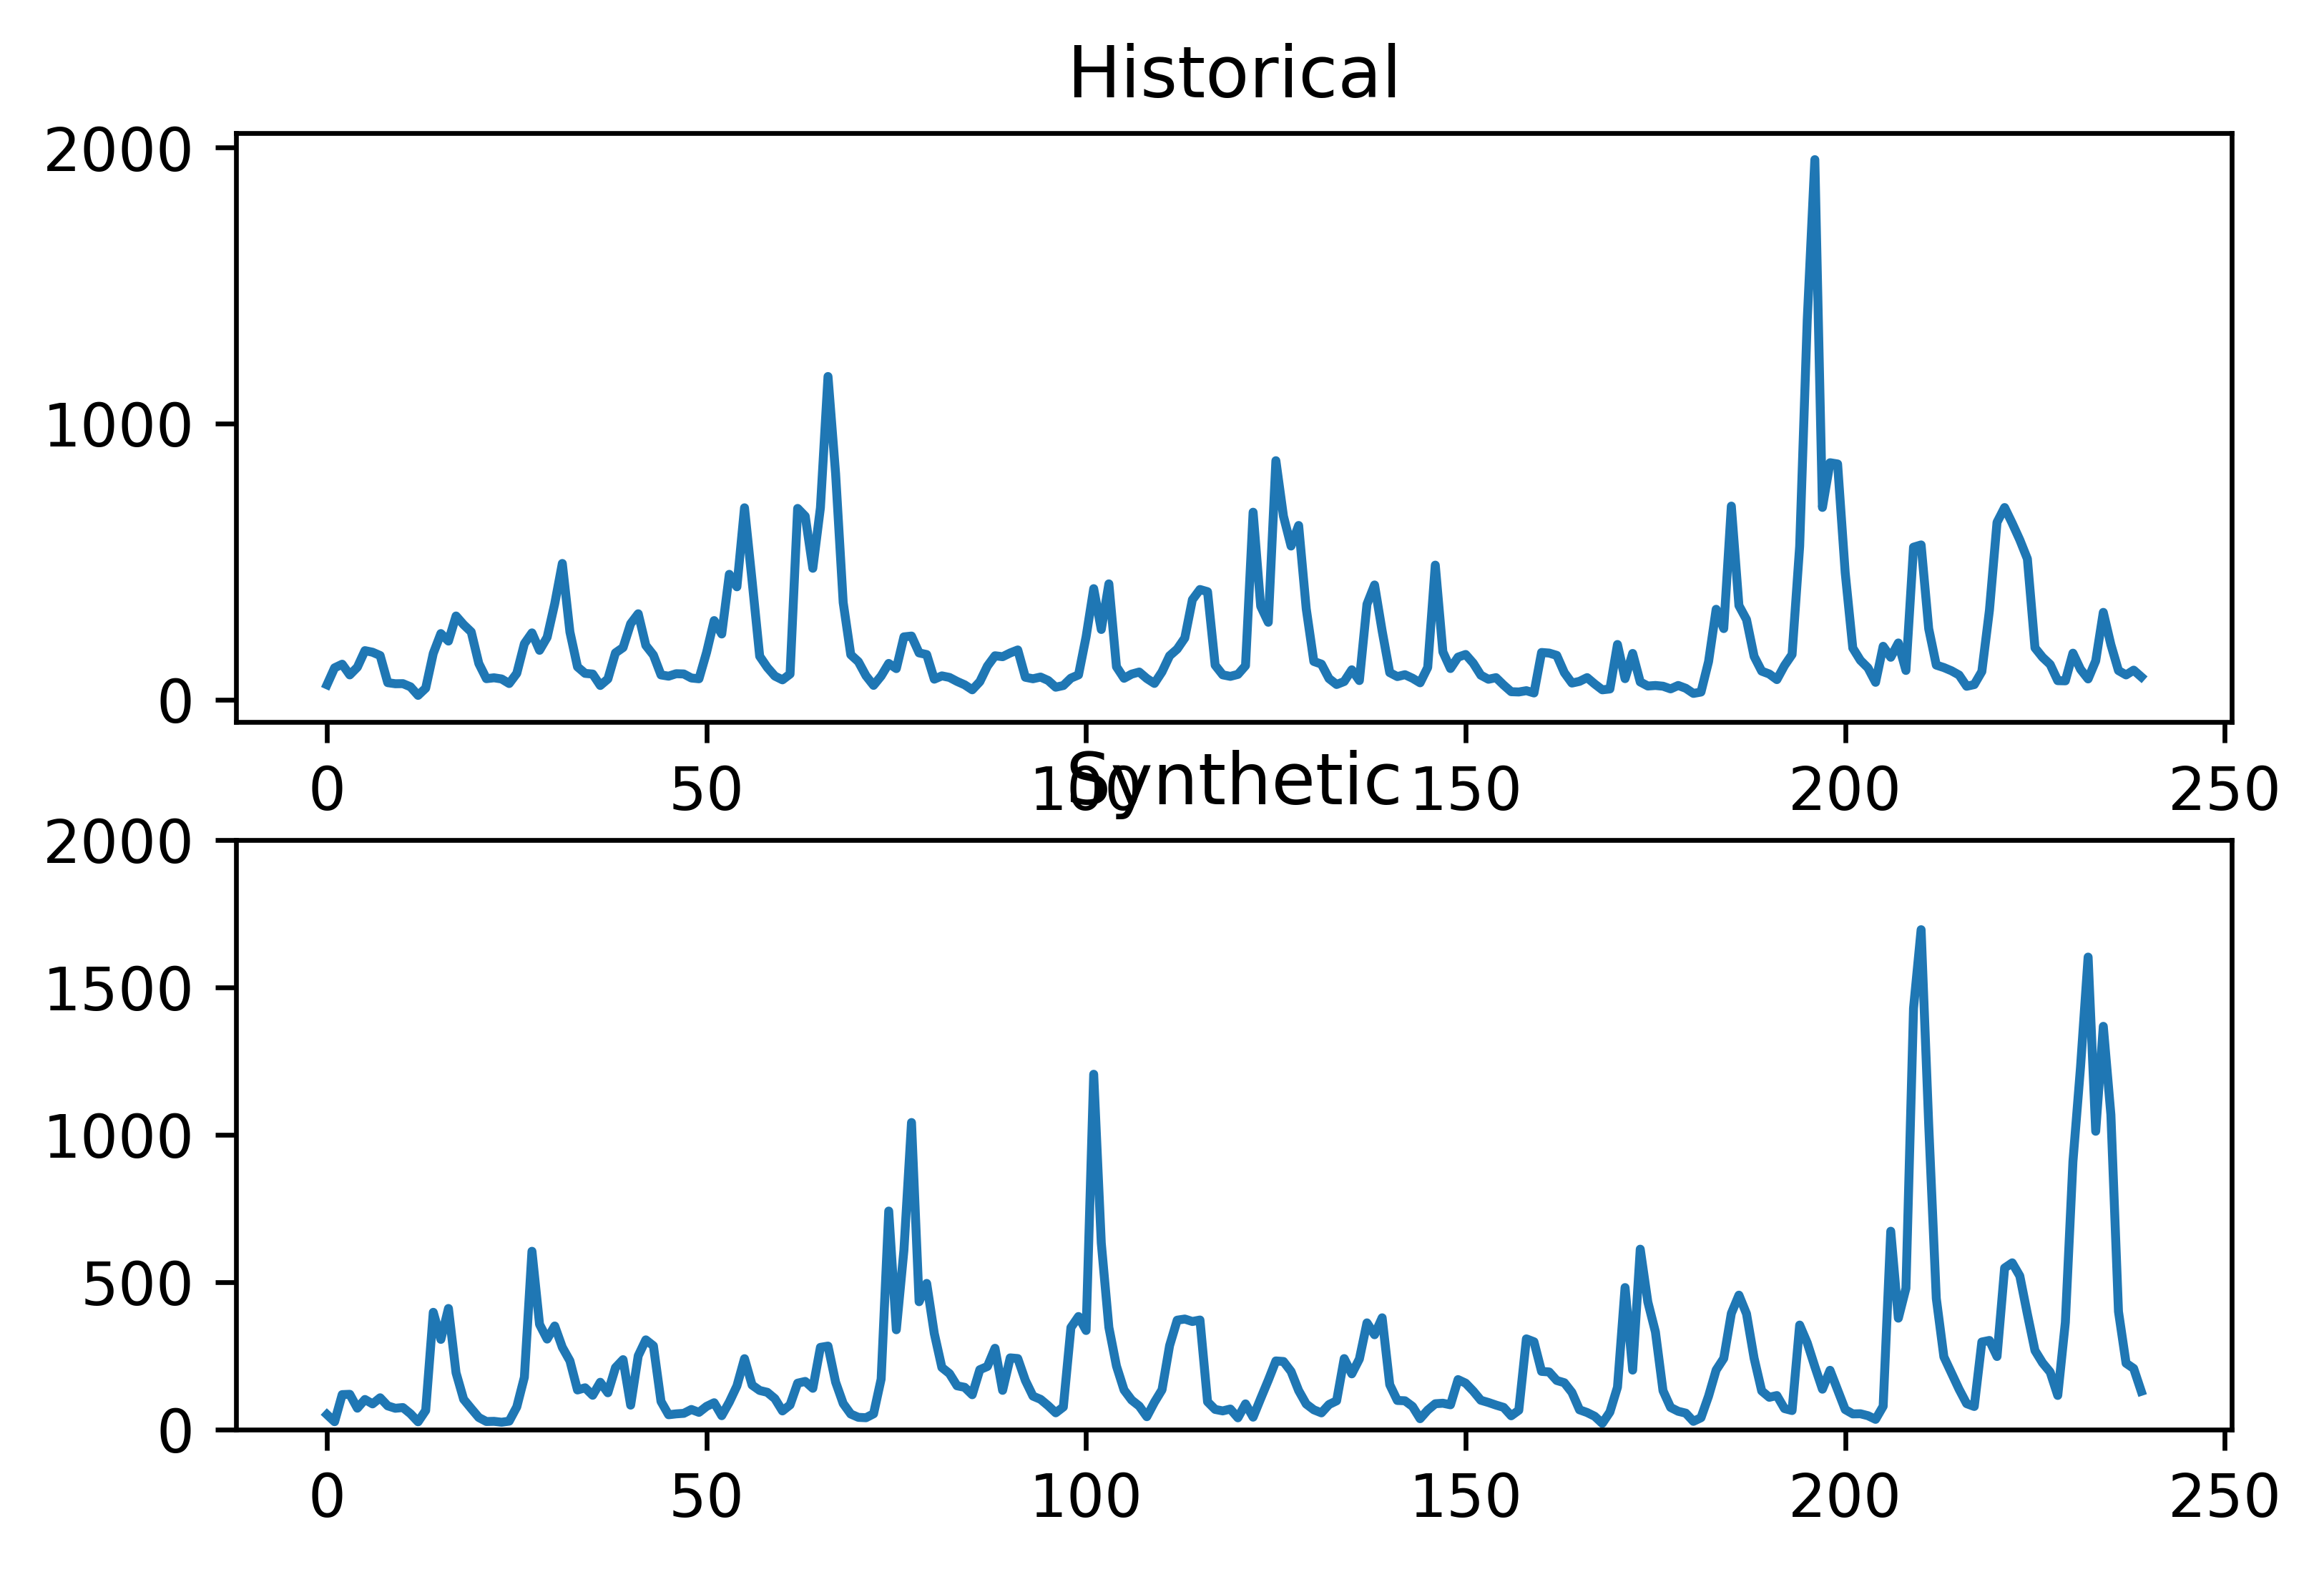

In [135]:
plt.subplot(2,1,1)
plt.plot(Q)
plt.title('Historical')
plt.subplot(2,1,2)
plt.title('Synthetic')
plt.plot(Q_synthetic)
plt.ylim([0,2000])
plt.show()

Compare ACF/PACF in historical and synthetic

In [ ]:
from statsmodels.tsa import stattools

In [ ]:
plt.subplot(2,2,1)
acf,ci = stattools.acf(Q, nlags = 12, alpha=0.05)
plt.plot(acf, linewidth=2)
plt.plot(ci, linestyle='dashed', color='0.5')
plt.title('ACF, Historical')

plt.subplot(2,2,2)
pacf,ci = stattools.pacf(Q, nlags = 12, alpha=0.05)
plt.plot(pacf, linewidth=2)
plt.plot(ci, linestyle='dashed', color='0.5')
plt.title('PACF, Historical')

plt.subplot(2,2,3)
acf,ci = stattools.acf(Q_synthetic, nlags = 12, alpha=0.05)
plt.plot(acf, linewidth=2)
plt.plot(ci, linestyle='dashed', color='0.5')
plt.title('ACF, Synthetic')

plt.subplot(2,2,4)
pacf,ci = stattools.pacf(Q_synthetic, nlags = 12, alpha=0.05)
plt.plot(pacf, linewidth=2)
plt.plot(ci, linestyle='dashed', color='0.5')
plt.title('PACF, Synthetic')

plt.show()